In [64]:
import yfinance as yf

# Fetch historical data for Google (GOOGL)
data_google = yf.download("GOOGL", start="2015-01-01", end="2023-01-01")
data_google.reset_index(inplace=True)
print(data_google.head())
type(data_google)
data_google.columns

[*********************100%***********************]  1 of 1 completed

Price                       Date  Adj Close      Close       High        Low  \
Ticker                                GOOGL      GOOGL      GOOGL      GOOGL   
0      2015-01-02 00:00:00+00:00  26.381865  26.477501  26.790001  26.393999   
1      2015-01-05 00:00:00+00:00  25.879185  25.973000  26.399500  25.887501   
2      2015-01-06 00:00:00+00:00  25.240501  25.332001  26.060499  25.277500   
3      2015-01-07 00:00:00+00:00  25.166271  25.257500  25.574499  25.182501   
4      2015-01-08 00:00:00+00:00  25.253952  25.345501  25.375000  24.750999   

Price        Open    Volume  
Ticker      GOOGL     GOOGL  
0       26.629999  26480000  
1       26.357500  41182000  
2       26.025000  54456000  
3       25.547501  46918000  
4       25.075500  73054000  


MultiIndex([(     'Date',      ''),
            ('Adj Close', 'GOOGL'),
            (    'Close', 'GOOGL'),
            (     'High', 'GOOGL'),
            (      'Low', 'GOOGL'),
            (     'Open', 'GOOGL'),
            (   'Volume', 'GOOGL')],
           names=['Price', 'Ticker'])

In [65]:
data_google = data_google.reset_index()
print(data_google['Date'].head())
data_google.columns

0   2015-01-02 00:00:00+00:00
1   2015-01-05 00:00:00+00:00
2   2015-01-06 00:00:00+00:00
3   2015-01-07 00:00:00+00:00
4   2015-01-08 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]


MultiIndex([(    'index',      ''),
            (     'Date',      ''),
            ('Adj Close', 'GOOGL'),
            (    'Close', 'GOOGL'),
            (     'High', 'GOOGL'),
            (      'Low', 'GOOGL'),
            (     'Open', 'GOOGL'),
            (   'Volume', 'GOOGL')],
           names=['Price', 'Ticker'])

In [66]:
import pandas as pd

# Reset index and flatten the MultiIndex columns
data_google = data_google.reset_index()
data_google.columns = [col[0] if col[1] == '' else f"{col[0]}_{col[1]}" for col in data_google.columns]

# Drop the 'index' column if it exists
if 'index' in data_google.columns:
    data_google = data_google.drop('index', axis=1)

# Create time index
data_google['time'] = range(len(data_google))

# Add group_id and convert to string type
data_google['group'] = 'GOOGL'  # Using stock ticker as group identifier

# Ensure all columns are properly named
columns_to_keep = ['Date', 'time', 'group', 'Adj Close_GOOGL', 'Close_GOOGL', 
                  'High_GOOGL', 'Low_GOOGL', 'Open_GOOGL', 'Volume_GOOGL']
data_google = data_google[columns_to_keep]

# Rename columns to remove the ticker suffix
data_google.columns = [col.split('_')[0] if '_' in col else col for col in data_google.columns]

print(data_google.head())


                       Date  time  group  Adj Close      Close       High  \
0 2015-01-02 00:00:00+00:00     0  GOOGL  26.381865  26.477501  26.790001   
1 2015-01-05 00:00:00+00:00     1  GOOGL  25.879185  25.973000  26.399500   
2 2015-01-06 00:00:00+00:00     2  GOOGL  25.240501  25.332001  26.060499   
3 2015-01-07 00:00:00+00:00     3  GOOGL  25.166271  25.257500  25.574499   
4 2015-01-08 00:00:00+00:00     4  GOOGL  25.253952  25.345501  25.375000   

         Low       Open    Volume  
0  26.393999  26.629999  26480000  
1  25.887501  26.357500  41182000  
2  25.277500  26.025000  54456000  
3  25.182501  25.547501  46918000  
4  24.750999  25.075500  73054000  


In [67]:
from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer

# Define parameters
max_prediction_length = 30  # Predict next 30 days
max_encoder_length = 120  # Use past 120 days as input
training_cutoff = data_google["time"].max() - max_prediction_length

# Create the dataset
training = TimeSeriesDataSet(
    data_google[lambda x: x.time <= training_cutoff],
    time_idx="time",
    target="Close",
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group"],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=["time"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["Open", "High", "Low", "Close", "Adj Close", "Volume"],
    target_normalizer=GroupNormalizer(groups=["group"], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# Create validation dataset
validation = TimeSeriesDataSet.from_dataset(training, data_google, min_prediction_idx=training_cutoff + 1)

# Create dataloaders
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [68]:
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import torch

class StockTFT(LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.model = tft_model
        self.automatic_optimization = True
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        raw_predictions = self.model(x)
        loss = self.model.loss(raw_predictions.prediction, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        raw_predictions = self.model(x)
        loss = self.model.loss(raw_predictions.prediction, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            patience=5,
            factor=0.5,
            verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss"
        }
    
    def predict(self, dataloader, mode="prediction", return_x=False, return_y=False):
        """
        Make predictions using the trained model
        
        Args:
            dataloader: DataLoader containing the prediction data
            mode: str, "prediction" or "raw" (default: "prediction")
            return_x: bool, if to return network inputs
            return_y: bool, if to return network targets
        """
        predictions = []
        self.eval()  # Set model to evaluation mode
        
        with torch.no_grad():
            for batch in dataloader:
                x, y = batch
                output = self.model(x)
                if mode == "prediction":
                    pred = output.prediction
                else:
                    pred = output
                predictions.append(pred)
        
        predictions = torch.cat(predictions, dim=0)
        
        if return_x or return_y:
            return predictions, x, y
        return predictions

# Modified model configuration
tft_params = dict(
    hidden_size=16,
    attention_head_size=2,
    dropout=0.2,
    hidden_continuous_size=8,
    output_size=7,
    loss=QuantileLoss(),
    learning_rate=0.001
)

# Create base model
base_tft = TemporalFusionTransformer.from_dataset(
    training,
    **tft_params
)

# Wrap model
tft = StockTFT(base_tft)

# Define trainer with modified settings
trainer = Trainer(
    max_epochs=50,
    accelerator='cpu',  # Force CPU for stability
    devices=1,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
    enable_progress_bar=True,
    log_every_n_steps=1
)

trainer.fit(tft, train_dataloader, val_dataloader)

c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\__init__.py:171: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will 

c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 6: 100%|██████████| 28/28 [00:06<00:00,  4.53it/s, v_num=28, train_loss=3.300, val_loss=19.20]


c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


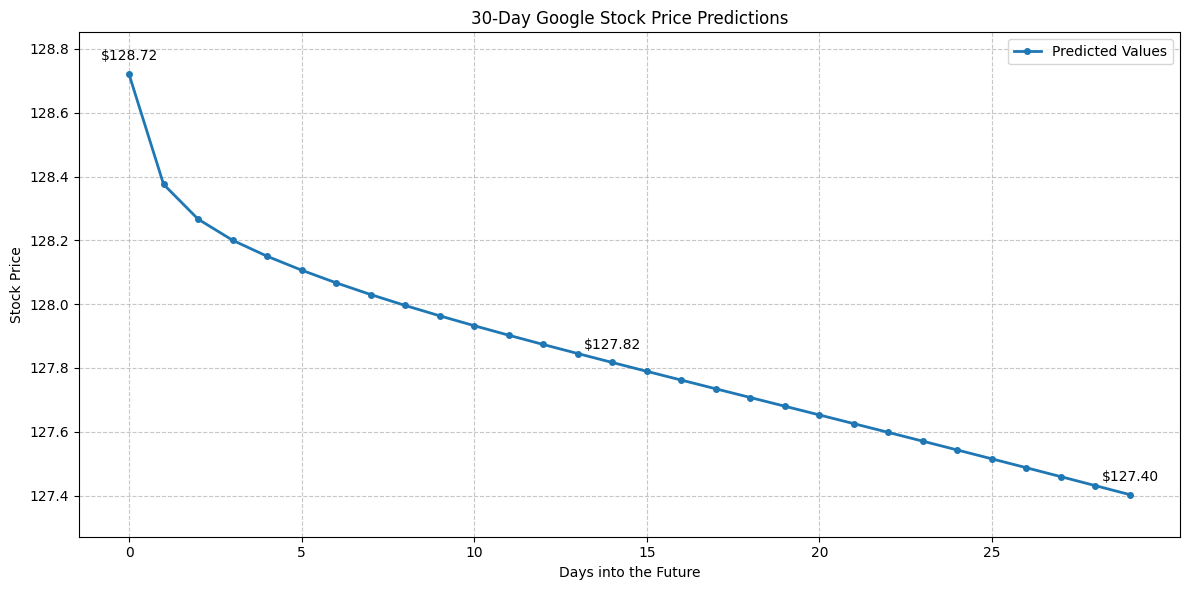


Prediction Statistics:
Starting price: $128.72
Ending price: $127.40
Average predicted price: $127.84
Price range: $1.32


In [74]:
import numpy as np
import matplotlib.pyplot as plt
# Set model to evaluation mode
tft.eval()

with torch.no_grad():
    # Get predictions using the model's predict method
    predictions = tft.model.predict(val_dataloader)

# Convert predictions to numpy
predictions_np = predictions.numpy()

# Create time steps for x-axis (30 days into the future)
future_time_steps = np.arange(30)

# Plot the predictions
plt.figure(figsize=(12, 6))

# Plot predictions
plt.plot(future_time_steps, predictions_np[0, :], 
         marker='o', label='Predicted Values', 
         linewidth=2, markersize=4)

plt.title('30-Day Google Stock Price Predictions')
plt.xlabel('Days into the Future')
plt.ylabel('Stock Price')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Add some padding to the y-axis
plt.margins(y=0.1)

# Customize x-axis ticks
plt.xticks(np.arange(0, 30, 5))

# Add value labels for a few key points
for i in [0, 14, 29]:  # Start, middle, and end points
    plt.annotate(f'${predictions_np[0, i]:.2f}', 
                (i, predictions_np[0, i]),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')

plt.tight_layout()
plt.show()

# Print some statistics about the predictions
print("\nPrediction Statistics:")
print(f"Starting price: ${predictions_np[0,0]:.2f}")
print(f"Ending price: ${predictions_np[0,-1]:.2f}")
print(f"Average predicted price: ${np.mean(predictions_np):.2f}")
print(f"Price range: ${np.ptp(predictions_np):.2f}")